# Bank Campaign Analysis/Modeling Part 2

In [13]:
#Import relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.datasets import make_blobs, make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import collections as coll
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [14]:
#import dataset

data = pd.read_csv('/Users/apple/Desktop/bank/bank.csv', delimiter=';')
display(data)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [15]:
#create variables

X = data.drop(columns='y')
y = data.y

In [16]:
#dropping variables

X.drop(columns = ['day', 'month', 'default', 'poutcome', 'duration'], inplace = True)

###### The same variables were dropped for the reasons explained in the assignment 1

In [17]:
#distribution of the target variable

y.value_counts() #unbalanced towards 'no'

no     4000
yes     521
Name: y, dtype: int64

###### This last information is very important because it is telling us that we should look into different metrics to evaluate the models!

## Question 1 

### Train a RandomForestClassifier: obtain the Confusion Matrix and plot the Precision vs Recall Curve. Comment on the results

In [18]:
#label encoder on target variable

lbl_e = LabelEncoder()
lbl_e.fit(y)
y = lbl_e.transform(y)
display(y)

array([0, 0, 0, ..., 0, 0, 0])

###### This transformation was made only to make the values clearer (either 1 or 0 rather than "No" and "Yes")

In [19]:
#Helper code

categorical = X.select_dtypes(include='object').columns
numerical = X.select_dtypes(exclude='object').columns

clt = make_column_transformer((StandardScaler(), numerical),(OrdinalEncoder(),
categorical))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_enc_tr = clt.fit_transform(X_train)
X_enc_ts = clt.transform(X_test)

In [20]:
#Train RandomForestClassifier

ens = RandomForestClassifier(n_estimators=10, random_state=42)
ens.fit(X_enc_tr, y_train)

print(ens.score(X_enc_tr, y_train))
print(ens.score(X_enc_ts, y_test))

0.9843657817109145
0.8850574712643678


###### Insight: the accuracy on the training set is very high, but it decreases considerably on the test set, indicating there exists overfitting because of the variation between the two. This is due to the fact that our model is uncapable to generalize as we would expect once new values are fed into it

In [21]:
#Predict values using RandomForestClassifier

preds = ens.predict(X_enc_ts)
display(preds)

array([0, 0, 0, ..., 0, 0, 1])

In [22]:
#produce classification report

report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1006
           1       0.41      0.10      0.16       125

    accuracy                           0.89      1131
   macro avg       0.66      0.54      0.55      1131
weighted avg       0.84      0.89      0.85      1131



###### Insight: again, as we can see the values for Precision and Recall are considerably high for class 0. The same cannot be stated for class 1 due to the very unbalanced dataset that we are analysing

In [23]:
#Get Confusion Matrix

cm1 = confusion_matrix(y_test, preds)                      #with absolute values
cm1_n = confusion_matrix(y_test, preds, normalize='true')  #with normalised values
display(cm1)
display(cm1_n)

array([[989,  17],
       [113,  12]])

array([[0.98310139, 0.01689861],
       [0.904     , 0.096     ]])

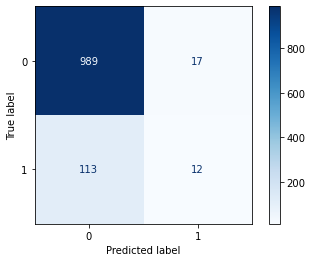

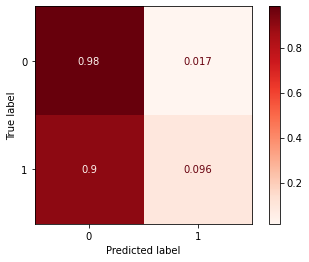

In [24]:
#Plot Confusion Matrix

cm1_plot = plot_confusion_matrix(ens, X_enc_ts, y_test, cmap=plt.cm.Blues)                     #with absolute values
cm1_n_plot = plot_confusion_matrix(ens, X_enc_ts, y_test, cmap=plt.cm.Reds, normalize= 'true') #with normalised values

In [25]:
#average Accuracy

balanced_accuracy_score(y_test, preds)

0.5395506958250497

###### Explanation: the balanced Accuracy, which is computed by calculating the weighted average of Recall between the two classes, is crucial when dealing with unbalanced dataset to have an overall view on the performance of the model, which in this case produces great results for class 0 but not for class 1

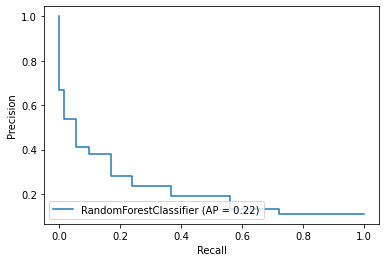

In [26]:
#Plot Precision vs Recall Curve

P_R_C1 = plot_precision_recall_curve(ens, X_enc_ts, y_test)

###### Insight: The results obtained are not promising, especially if we take into account the underrepresented class. Indeed, we can see by looking at the normalised confusion matrix, that it shows a very little value for the recall of class 1. This is due to the fact that only 11.5% of observations show this latter value for the target variable. The main difference between only examining the Accuracy vs also taking into account the Precision and the Recall consists of having the chance to break down the analysis for the different classes in evaluating the model; in fact the Precision is computed as (TP/(TP+FP)) and the Recall is computed as (TP/(TP+FN)). Furthermore, this is the best example to see how important these two metrics are because, although the accuracy reaches 98% on the training set, the recall is only of around 10% for class 1. Finally, by examining the Precision vs Recall curve we can see how trying to improve the recall marginally affects the level of the Recall previously achieved, which indicates a very bad tradeoff between the two metrics considering this model

# Question 2

### Application of PCA and Variance Analysis

In [27]:
#PCA application

pca = PCA(n_components= 4, random_state=42).fit(X_enc_tr)
X_pca_tr = pca.transform(X_enc_tr)
print(pca.explained_variance_ratio_)
display(pd.DataFrame(pca.components_, columns=X.columns))

[0.59879364 0.09542593 0.0654993  0.05628406]


,age,job,marital,education,balance,housing,loan,contact,campaign,pdays,previous
0,-0.006656,0.002255,-0.004156,-0.010319,-0.002177,0.998490,0.012049,0.043501,-0.020314,-0.005355,-0.019015
1,-0.024087,0.061357,-0.153828,0.670132,0.652505,-0.000521,0.029636,0.046504,0.016059,-0.007516,-0.306262
2,0.813874,0.504611,-0.087492,-0.013518,0.004097,0.008824,-0.240250,-0.087208,-0.095001,-0.018119,0.019137
3,-0.118952,0.400530,0.887526,0.028322,0.067554,-0.005612,0.074089,0.100341,-0.014257,-0.008857,-0.128402


In [28]:
#Variance explained by the 4 principal components

print(sum(pca.explained_variance_ratio_)) 

0.8160029314247714


###### Insight: the Variance represented in the 4 principal components from the initial dataset is equal to 0.816

# Question 3 

### Using the PCA transformation and a RandomForestClassifier (n_estimators=10), score the model (accuracy) and compute/plot the confusion matrix.

In [29]:
#Application of PCA on the test set

X_pca_ts = pca.transform(X_enc_ts)

In [30]:
ens1 = RandomForestClassifier(n_estimators=10, random_state=42)
ens1.fit(X_pca_tr, y_train)
print(ens1.score(X_pca_tr, y_train))
print(ens1.score(X_pca_ts, y_test))

0.9828908554572271
0.8841732979664014


###### Insight: we can identify the presence of overfitting due to the variation of the Accuracy between the training and test set, indicating that the model is not generalizing correctly when it is fed with new data

In [31]:
#get predictions 

preds1 = ens1.predict(X_pca_ts)
display(preds1)

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
#produce classification report

report = classification_report(y_test, preds1)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1006
           1       0.36      0.06      0.11       125

    accuracy                           0.88      1131
   macro avg       0.63      0.53      0.52      1131
weighted avg       0.84      0.88      0.85      1131



###### Insight: the Recall is even worse for this model when looking at class 1 compared to the previous model (0.06 vs 0.1), while the values for the metrics for class 0 are almost overlapped with the ones of the previous model

In [33]:
#get Confusion Matrix

cm2 = confusion_matrix(y_test, preds1)                      #with absolute values
cm2_n = confusion_matrix(y_test, preds1, normalize='true')   #with normalised values
display(cm2)
display(cm2_n)

array([[992,  14],
       [117,   8]])

array([[0.9860835, 0.0139165],
       [0.936    , 0.064    ]])

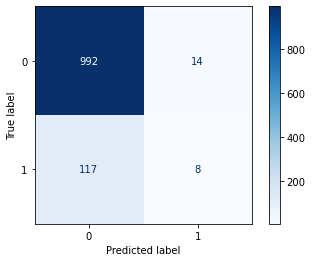

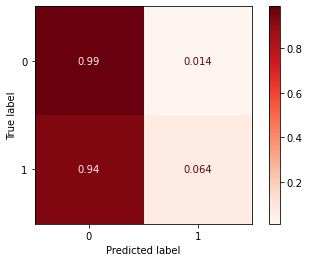

In [34]:
#plot Confusion Matrix

cm2_plot = plot_confusion_matrix(ens1, X_pca_ts, y_test, cmap=plt.cm.Blues)                     #with absolute values
cm2_n_plot = plot_confusion_matrix(ens1, X_pca_ts, y_test, cmap=plt.cm.Reds, normalize= 'true') #with normalised values

In [35]:
#average Accuracy

balanced_accuracy_score(y_test, preds1)

0.5250417495029821

###### Explanation: again we produce the balanced Accuracy for the two classes to have a complete view on the performance of the model. This time it appears to have worsened compared to the previous model

## Question 4

### Using GridSearchCV optimize the model to maximize 'recall', once it is optimized obtain the best parameters, a classification report of the model and the confusion matrix.
### (Optional) use the 'balanced_accuracy_score' function to verify/extract more conclusions.

In [36]:
#Grid Search on previous model

parameters_rf = {'criterion':['gini'], 'n_estimators':[10,20], 'max_depth':[5,6,7]}
rgs = GridSearchCV(ens1, parameters_rf, scoring='recall' , n_jobs=4)
rgs.fit(X_enc_tr, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=10, random_state=42),
             n_jobs=4,
             param_grid={'criterion': ['gini'], 'max_depth': [5, 6, 7],
                         'n_estimators': [10, 20]},
             scoring='recall')

In [37]:
#results

print(rgs.best_estimator_)
print(rgs.best_params_)
print(rgs.best_score_)

RandomForestClassifier(max_depth=7, n_estimators=10, random_state=42)
{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 10}
0.05813291139240506


In [38]:
#best model

best_model = rgs.best_estimator_
best_model.fit(X_enc_tr, y_train)
print(best_model.score(X_enc_tr, y_train))
print(best_model.score(X_enc_ts, y_test))

0.9008849557522124
0.8824049513704686


###### Insight: the first improvement we can notice is the huge decrease in overfitting, indeed we have lowered considerably the variation of Accuracy between the train and test set

In [39]:
#get predictions

preds2 = best_model.predict(X_enc_ts)

In [40]:
#produce classification report

report = classification_report(y_test, preds2)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1006
           1       0.17      0.02      0.03       125

    accuracy                           0.88      1131
   macro avg       0.53      0.50      0.48      1131
weighted avg       0.81      0.88      0.84      1131



###### Insight: by lowering overfitting, unfortunately, we also impacted the overall quality of the model in the single classes. Indeed, this latter model performs even worse in class 1

In [41]:
#get Confusion Matrix

cm3 = confusion_matrix(y_test, preds2)                      #with absolute values
cm3_n = confusion_matrix(y_test, preds2, normalize='true')  #with normalised values
display(cm3)
display(cm3_n)

array([[996,  10],
       [123,   2]])

array([[0.99005964, 0.00994036],
       [0.984     , 0.016     ]])

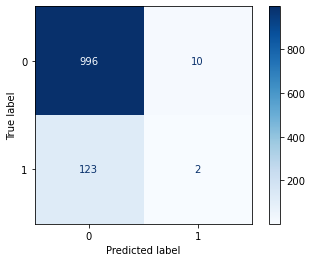

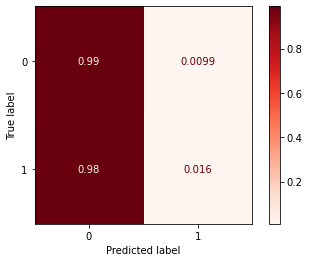

In [42]:
#plot Confusion Matrix

cm3_plot = plot_confusion_matrix(best_model, X_enc_ts, y_test, cmap=plt.cm.Blues)                     #with absolute values
cm3_n_plot = plot_confusion_matrix(best_model, X_enc_ts, y_test, cmap=plt.cm.Reds, normalize= 'true') #with normalised values

In [43]:
#average Accuracy 

balanced_accuracy_score(y_test, preds2)

0.5030298210735586

###### Explanation: again, we produced the balanced Accuracy on both classes and it is the lowest so far compared to the other models

## Question 5

### Using the provided code, the StratifiedKFold and GridSearchCV functions; optimize and validate the model with the recall metric.
### - Justify the obtained results and compare them with the ones obtained in question 1 and 3.
### - (Optional) obtain the confusion matrix and the report from the model with higher score.

In [44]:
#utilize pipeline for Cross Validation and Grid Search

pipe = Pipeline(steps=[('pre',make_column_transformer((StandardScaler(), numerical), (OrdinalEncoder(), categorical))),('SVM',SVC())])
parameters1 = {'SVM__kernel':['linear','rbf'],'SVM__C':np.linspace(0.01,10,5), 'SVM__gamma':np.linspace(0.01,10,5)}

gs = GridSearchCV(pipe, parameters1, scoring='recall', cv=5)
kf = StratifiedKFold(shuffle=True, n_splits=5, random_state=42)
cv = cross_validate(gs, X, y, cv=kf, n_jobs=4, return_estimator=True)

In [49]:
print(cv)
print(cv['test_score'].mean())

{'fit_time': array([3844.41785192, 4114.04802704, 4072.24600124, 3653.45295   ,
       2122.86991382]), 'score_time': array([0.13281989, 0.07411218, 0.11574459, 0.12840605, 0.06173801]), 'estimator': (GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         Index(['age', 'balance', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(),
                                                                         Index(['job', 'marital', 'education', 'housing', 'loan', 'contact'], dtype='object'))])),
                                       ('SVM', SVC())]),

###### Insight: we see no improvement on the Recall even after executing Cross Validation

In [46]:
#Model selection

best_model1 = cv['estimator'][2].best_estimator_['SVM']

###### Insight: the best model resulted to be the third one as we can see from the above report, resulting in a Recall of 0.077

###### Explanation: the following part was done to test the obtained model through Cross Validation on the original test set. It is to be noted that this is not a good practice since the observations contained in the original test set could possibily have been used to train the best model during Cross Validation. Either way, this last step was performed in order to see how it would have performed and, indeed, it shows a very high value for the recall of class 1

In [133]:
#Get predictions

preds4 = best_model1.predict(X_enc_ts)

In [134]:
#Get Confusion Matrix

cm4 = confusion_matrix(y_test, preds4)                      #with absolute values
cm4_n = confusion_matrix(y_test, preds4, normalize='true')  #with normalised values
display(cm4)
display(cm4_n)

array([[998,   8],
       [ 31,  94]])

array([[0.99204771, 0.00795229],
       [0.248     , 0.752     ]])

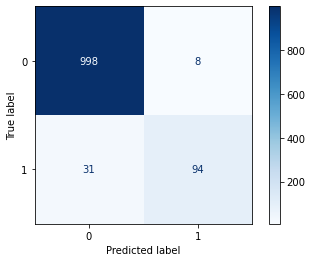

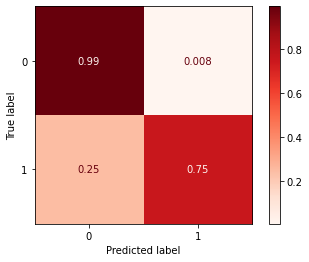

In [125]:
#Plot Confusion Matrix

cm4_plot = plot_confusion_matrix(best_model1, X_enc_ts, y_test, cmap=plt.cm.Blues)                     #with absolute values
cm4_n_plot = plot_confusion_matrix(best_model1, X_enc_ts, y_test, cmap=plt.cm.Reds, normalize= 'true') #with normalised values

In [135]:
#Produce Classification Report

report = classification_report(y_test, preds4)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1006
           1       0.92      0.75      0.83       125

    accuracy                           0.97      1131
   macro avg       0.95      0.87      0.90      1131
weighted avg       0.96      0.97      0.96      1131



In [136]:
#average Accuracy 

balanced_accuracy_score(y_test, preds4)

0.872023856858847

###### Insight: this last model shows the best metrics compared to the previous ones when used on the original test set. Again, we should not take these results as real improvements because of the way Cross Validation is performed, but as additional steps for the curiosity of the reader